# Convolutional Neural Networks (CNN)
<font color='blue'>
<br>Content: 
* [Loading the Data Set](#1)
* [Normalization, Reshape and Label Encoding ](#2)
* [Train Test Split](#3)
* [Convolutional Neural Network](#4)
    * [What is Convolution Operation?](#5)
    * [Same Padding](#6)
    * [Max Pooling](#7)
    * [Flattening](#8)
    * [Full Connection](#9)
* [Implementing with Keras](#10)
    * [Create Model](#11)
    * [Define Optimizer](#12)
    * [Compile Model](#13)
    * [Epochs and Batch Size](#14)
    * [Data Augmentation](#15)
    * [Fit the Model](#16)
    * [Evaluate the Model](#17)
* [Deep Learning Tutorial for Beginners](https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners)
* [Artificial Neural Network with Pytorch](https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers)
* [Convolutional Neural Network with Pytorch](https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers)
* [Recurrent Neural Network with Pytorch](https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch)
* [Conclusion](#18)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv']


In [23]:
import numpy as np

# Activation functions
def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)

def softmax(x):
    x -= np.max(x, axis=1, keepdims=True)
    e_x = np.exp(x)
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy(predictions, targets):
    N = predictions.shape[0]
    return -np.sum(targets * np.log(predictions + 1e-8)) / N

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

# Layers
class Dense:
    def __init__(self, in_features, out_features, lr=0.01,beta1=0.9, beta2=0.999, epsilon=1e-8):
        # self.w = np.random.randn(in_features, out_features) * np.sqrt(2. / in_features)
        # self.b = np.zeros(out_features)
        # self.lr = lr


        self.w = np.random.randn(in_features, out_features) * np.sqrt(2. / in_features)
        self.b = np.zeros(out_features)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0  # timestep

        self.m_w = np.zeros_like(self.w)
        self.v_w = np.zeros_like(self.w)
        self.m_b = np.zeros_like(self.b)
        self.v_b = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return x @ self.w + self.b

    def simple_backward(self, grad_output):
        grad_input = grad_output @ self.w.T
        grad_w = self.x.T @ grad_output
        grad_b = np.sum(grad_output, axis=0)
        self.w -= self.lr * grad_w
        self.b -= self.lr * grad_b
        
        return grad_input

    def adam_backward(self, grad_output):
            # ########
            grad_w = self.x.T @ grad_output
            grad_b = np.sum(grad_output, axis=0)
            grad_input = grad_output @ self.w.T
    
            self.t += 1
    
            # Update weights with Adam
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * grad_w
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (grad_w ** 2)
            m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w / (1 - self.beta2 ** self.t)
    
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * grad_b
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (grad_b ** 2)
            m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b / (1 - self.beta2 ** self.t)
    
            self.w -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            self.b -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
    
            
            return grad_input

class Flatten:
    def forward(self, x):
        self.x_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, grad_output):
        return grad_output.reshape(self.x_shape)

class SimpleReLU:
    def forward(self, x):
        self.x = x
        return relu(x)

    def backward(self, grad_output):
        return grad_output * relu_deriv(self.x)

class SimpleSoftmaxLoss:
    def forward(self, x, y):
        self.y = y
        self.out = softmax(x)
        return cross_entropy(self.out, y)

    def backward(self):
        return (self.out - self.y) / self.y.shape[0]



<a id="1"></a>
## Loading the Data Set
* In this part we load and visualize the data.

In [4]:
# read train 
train = pd.read_csv("../input/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# read test 
test= pd.read_csv("../input/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# put labels into y_train variable
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

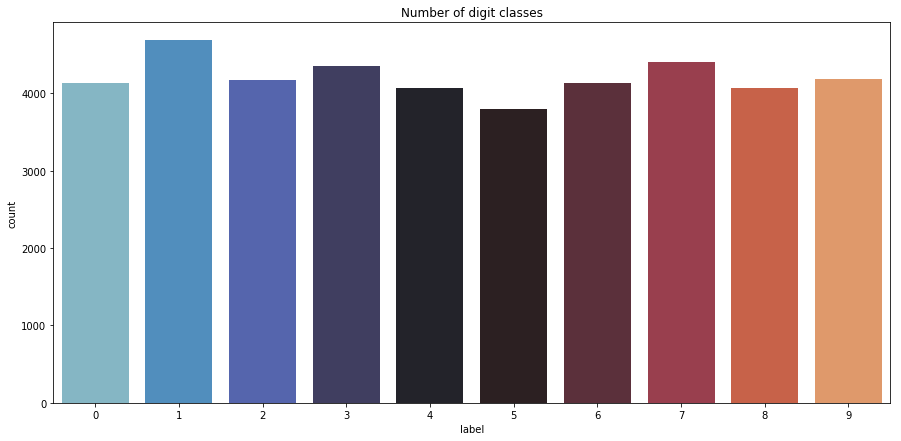

In [7]:
# visualize number of digits classes
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()

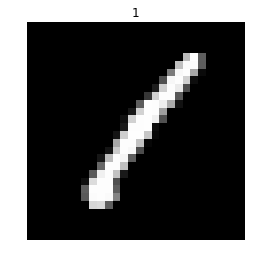

In [8]:
# plot some samples
img = X_train.iloc[0].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

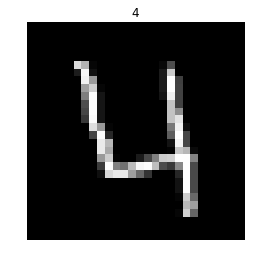

In [9]:
# plot some samples
img = X_train.iloc[3].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[3,0])
plt.axis("off")
plt.show()

<a id="2"></a>
## Normalization, Reshape and Label Encoding 
* Normalization
    * We perform a grayscale normalization to reduce the effect of illumination's differences.
    * If we perform normalization, CNN works faster.
* Reshape
    * Train and test images (28 x 28) 
    * We reshape all data to 28x28x1 3D matrices.
    * Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel. 
* Label Encoding  
    * Encode labels to one hot vectors 
        * 2 => [0,0,1,0,0,0,0,0,0,0]
        * 4 => [0,0,0,0,1,0,0,0,0,0]

In [10]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 784)
test shape:  (28000, 784)


In [11]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [12]:
# Label Encoding 
Y_train = one_hot(Y_train, num_classes = 10)

In [15]:
# 
# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
# Y_train_keras = to_categorical(Y_train, num_classes = 10)

<a id="3"></a>
## Train Test Split
* We split the data into train and test sets.
* test size is 10%.
* train size is 90%.

In [13]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


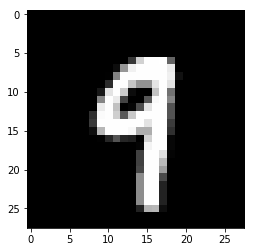

In [14]:
# Some examples
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

<a id="4"></a>
## Convolutional Neural Network 
* CNN is used for image classification, object detection 
* <a href="https://ibb.co/kV1j9p"><img src="https://preview.ibb.co/nRkBpp/gec2.jpg" alt="gec2" border="0"></a>

<a id="5"></a>
### What is Convolution Operation?
* We have some image and feature detector(3*3)
* Feature detector does not need to be 3 by 3 matrix. It can be 5 by 5 or 7 by 7.
* Feature detector = kernel = filter
* Feauture detector detects features like edges or convex shapes. Example, if out input is dog, feature detector can detect features like ear or tail of the dog.
* feature map = conv(input image, feature detector). Element wise multiplication of matrices.
* feature map = convolved feature
* Stride = navigating in input image.
* We reduce the size of image. This is important bc code runs faster. However, we lost information. 
* We create multiple feature maps bc we use multiple feature detectors(filters).
* Lets look at gimp. Edge detect: [0,10,0],[10,-4,10],[0,10,0]
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/m4FQC9/gec.jpg" alt="gec" border="0"></a>
* After having convolution layer we use ReLU to break up linearity. Increase nonlinearity. Because images are non linear.
* <a href="https://ibb.co/mVZih9"><img src="https://preview.ibb.co/gbcQvU/RELU.jpg" alt="RELU" border="0"></a>

<a id="6"></a>
### Same Padding
* As we keep applying conv layers, the size of the volume will decrease faster than we would like. In the early layers of our network, we want to preserve as much information about the original input volume so that we can extract those low level features.
* input size and output size are same.
* <a href="https://ibb.co/jUPkUp"><img src="https://preview.ibb.co/noH5Up/padding.jpg" alt="padding" border="0"></a>

<a id="7"></a>
### Max Pooling
* It makes down-sampling or sub-sampling (Reduces the number of parameters)
* It makes the detection of features invariant to scale or orientation changes.
* It reduce the amount of parameters and computation in the network, and hence to also control overfitting. 
* <a href="https://ibb.co/ckTjN9"><img src="https://preview.ibb.co/gsNYFU/maxpool.jpg" alt="maxpool" border="0"></a>

<a id="8"></a>
### Flattening
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/c7eVvU/flattenigng.jpg" alt="flattenigng" border="0"></a>

<a id="9"></a>
### Full Connection
* Neurons in a fully connected layer have connections to all activations in the previous layer
* Artificial Neural Network
* <a href="https://ibb.co/hsS14p"><img src="https://preview.ibb.co/evzsAU/fullyc.jpg" alt="fullyc" border="0"></a>

<a id="10"></a>
## Implementing with Keras

<a id="11"></a>
### Create Model
* conv => max pool => dropout => conv => max pool => dropout => fully connected (2 layer)
* Dropout: Dropout is a technique where randomly selected neurons are ignored during training
* <a href="https://ibb.co/jGcvVU"><img src="https://preview.ibb.co/e7yPPp/dropout.jpg" alt="dropout" border="0"></a>

In [37]:

from sklearn.metrics import confusion_matrix
# import itertools

# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# from keras.optimizers import RMSprop,Adam
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ReduceLROnPlateau

# model = Sequential()
# #
# model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu', input_shape = (28,28,1)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# #
# model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))
# # fully connected
# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation = "softmax"))

In [17]:
import numpy as np

# Evaluation function
def train_evaluate(X, y_true, dense1, relu1, dense2, loss_fn):
    out = dense1.forward(X)
    out = relu1.forward(out)
    out = dense2.forward(out)
    loss = loss_fn.forward(out, y_true)

    predictions = np.argmax(loss_fn.out, axis=1)
    labels = np.argmax(y_true, axis=1)
    acc = np.mean(predictions == labels)
    return loss, acc

def valid_evaluate(model_layers, loss_fn, X, y_true):
    """
    model_layers: list of model layers in order
    loss_fn: instance of SimpleSoftmaxLoss
    X: input data (N, features)
    y_true: true one-hot encoded labels
    """
    out = X
    for layer in model_layers:
        if isinstance(layer, SimpleSoftmaxLoss):
            break
        out = layer.forward(out)

    # Compute loss
    loss = loss_fn.forward(out, y_true)

    # Compute accuracy
    predictions = np.argmax(loss_fn.out, axis=1)
    labels = np.argmax(y_true, axis=1)
    acc = np.mean(predictions == labels)
    return loss, acc

In [ ]:
# Assuming X_train and Y_train are already available
X_train = X_train.reshape(37800, -1)  # Flatten (N, 28, 28) to (N, 784)
# Y_train = one_hot(Y_train, num_classes = 10)      # Make sure Y_train is one-hot encoded

# You must also have a validation set, e.g.:
X_val = X_val.reshape(4200, -1)  # Flatten (N, 28, 28) to (N, 784)
# Y_val = one_hot(Y_val, 10)


In [20]:

dense1 = Dense(784, 128)
relu1 = SimpleReLU()
dense2 = Dense(128, 10)
loss_fn = SimpleSoftmaxLoss()

losses, train_accs = [], []

# Training loop
for epoch in range(100):
    # Forward
    out = dense1.forward(X_train)
    out = relu1.forward(out)
    out = dense2.forward(out)
    loss = loss_fn.forward(out, Y_train)

    # Backward
    grad = loss_fn.backward()
    grad = dense2.simple_backward(grad)
    grad = relu1.backward(grad)
    grad = dense1.simple_backward(grad)

    # Evaluate on training
    train_loss, train_acc = train_evaluate(X_train, Y_train, dense1, relu1, dense2, loss_fn)

    # Optionally, also evaluate on validation if available
    model = [
            dense1,
            relu1,
            dense2,
            loss_fn
        ]
    val_loss, val_acc = valid_evaluate(model, model[-1], X_val, Y_val)

    losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Epoch {epoch + 1} - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"           Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1 - Loss: 2.3362, Accuracy: 0.1020
           Val Loss: 2.3412, Val Accuracy: 0.1029
Epoch 2 - Loss: 2.3209, Accuracy: 0.1053
           Val Loss: 2.3259, Val Accuracy: 0.1076
Epoch 3 - Loss: 2.3062, Accuracy: 0.1097
           Val Loss: 2.3114, Val Accuracy: 0.1133
Epoch 4 - Loss: 2.2922, Accuracy: 0.1148
           Val Loss: 2.2974, Val Accuracy: 0.1171
Epoch 5 - Loss: 2.2787, Accuracy: 0.1216
           Val Loss: 2.2840, Val Accuracy: 0.1233
Epoch 6 - Loss: 2.2657, Accuracy: 0.1292
           Val Loss: 2.2710, Val Accuracy: 0.1283
Epoch 7 - Loss: 2.2531, Accuracy: 0.1380
           Val Loss: 2.2584, Val Accuracy: 0.1369
Epoch 8 - Loss: 2.2409, Accuracy: 0.1469
           Val Loss: 2.2462, Val Accuracy: 0.1476
Epoch 9 - Loss: 2.2290, Accuracy: 0.1568
           Val Loss: 2.2342, Val Accuracy: 0.1564
Epoch 10 - Loss: 2.2174, Accuracy: 0.1667
           Val Loss: 2.2226, Val Accuracy: 0.1640
Epoch 11 - Loss: 2.2060, Accuracy: 0.1768
           Val Loss: 2.2113, Val Accuracy: 0.17

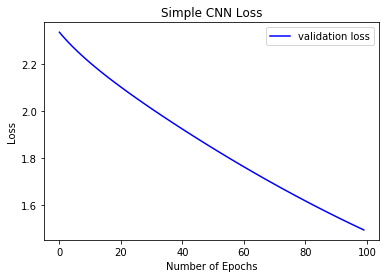

In [21]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(losses, color='b', label="validation loss")
plt.title("Simple CNN Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:

dense1 = Dense(784, 128)
relu1 = SimpleReLU()
dense2 = Dense(128, 10)
loss_fn = SimpleSoftmaxLoss()

losses, train_accs = [], []

# Training loop
for epoch in range(100):
    # Forward
    out = dense1.forward(X_train)
    out = relu1.forward(out)
    out = dense2.forward(out)
    loss = loss_fn.forward(out, Y_train)

    # Backward
    grad = loss_fn.backward()
    grad = dense2.adam_backward(grad)
    grad = relu1.backward(grad)
    grad = dense1.adam_backward(grad)

    # Evaluate on training
    train_loss, train_acc = train_evaluate(X_train, Y_train, dense1, relu1, dense2, loss_fn)

    # Optionally, also evaluate on validation if available
    model = [
            dense1,
            relu1,
            dense2,
            loss_fn
        ]
    val_loss, val_acc = valid_evaluate(model, model[-1], X_val, Y_val)

    losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Epoch {epoch + 1} - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"           Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1 - Loss: 1.4267, Accuracy: 0.6047
           Val Loss: 1.4339, Val Accuracy: 0.6000
Epoch 2 - Loss: 0.9425, Accuracy: 0.7186
           Val Loss: 0.9656, Val Accuracy: 0.7124
Epoch 3 - Loss: 0.7025, Accuracy: 0.7855
           Val Loss: 0.7081, Val Accuracy: 0.7762
Epoch 4 - Loss: 0.5916, Accuracy: 0.8160
           Val Loss: 0.5876, Val Accuracy: 0.8107
Epoch 5 - Loss: 0.4908, Accuracy: 0.8524
           Val Loss: 0.4919, Val Accuracy: 0.8460
Epoch 6 - Loss: 0.4743, Accuracy: 0.8495
           Val Loss: 0.4779, Val Accuracy: 0.8512
Epoch 7 - Loss: 0.4304, Accuracy: 0.8730
           Val Loss: 0.4310, Val Accuracy: 0.8676
Epoch 8 - Loss: 0.4116, Accuracy: 0.8793
           Val Loss: 0.4093, Val Accuracy: 0.8781
Epoch 9 - Loss: 0.3860, Accuracy: 0.8878
           Val Loss: 0.3832, Val Accuracy: 0.8871
Epoch 10 - Loss: 0.3662, Accuracy: 0.8942
           Val Loss: 0.3667, Val Accuracy: 0.8883
Epoch 11 - Loss: 0.3634, Accuracy: 0.8943
           Val Loss: 0.3680, Val Accuracy: 0.88

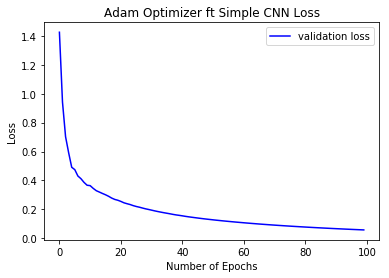

In [25]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(losses, color='b', label="validation loss")
plt.title("Adam Optimizer ft Simple CNN Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [35]:
def predict(X, dense1, relu1, dense2):
    out = dense1.forward(X)
    out = relu1.forward(out)
    out = dense2.forward(out)
    out = softmax(out)  # converts logits to class probabilities
    # return np.argmax(out, axis=1)  # returns class index
    return out  # returns class index

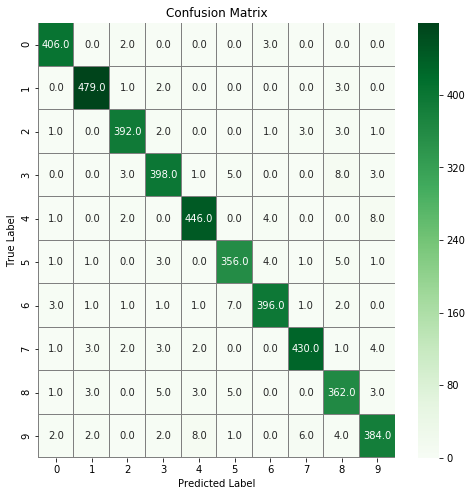

In [38]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = predict(X_val, dense1, relu1, dense2)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [43]:
from sklearn.metrics import classification_report


# True and predicted labels
true_labels = []
pred_labels = []
for i in range(10):
    for j in range(10):
        true_labels.extend([i] * int(confusion_mtx[i][j]))
        pred_labels.extend([j] * int(confusion_mtx[i][j]))

# Calculate classification report
report = classification_report(true_labels, pred_labels, output_dict=True)
report_table = [(label, round(m['precision'], 3), round(m['recall'], 3), round(m['f1-score'], 3)) 
                for label, m in report.items() if label.isdigit()]

df = pd.DataFrame(report_table, columns=['Class', 'Precision', 'Recall', 'F1-Score'])
df

,Class,Precision,Recall,F1-Score
0,0,0.976,0.988,0.982
1,1,0.980,0.988,0.984
2,2,0.973,0.973,0.973
3,3,0.957,0.952,0.954
4,4,0.967,0.967,0.967
5,5,0.952,0.957,0.954
6,6,0.971,0.959,0.965
7,7,0.975,0.964,0.970
8,8,0.933,0.948,0.940
9,9,0.950,0.939,0.945


In [47]:
class ResidualBlock:
    def __init__(self, size, lr=0.001):
        self.dense1 = Dense(size, size, lr=lr)
        self.relu1 = SimpleReLU()
        self.dense2 = Dense(size, size, lr=lr)
        self.relu2 = SimpleReLU()

    def forward(self, x):
        self.input = x
        out = self.dense1.forward(x)
        out = self.relu1.forward(out)
        out = self.dense2.forward(out)
        out = out + x  # Residual connection
        out = self.relu2.forward(out)
        self.out = out
        return out

    def backward(self, grad_output):
        grad = self.relu2.backward(grad_output)
        grad_residual = grad  # Skip path
        grad = self.dense2.adam_backward(grad)
        grad = self.relu1.backward(grad)
        grad = self.dense1.adam_backward(grad)
        return grad + grad_residual  # Add gradients through residual


In [51]:
# flatten = Flatten()
dense_in = Dense(784, 128, lr=0.001)
relu_in = SimpleReLU()
res_block = ResidualBlock(128, lr=0.001)
dense_out = Dense(128, 10, lr=0.001)
loss_fn = SimpleSoftmaxLoss()
losses, train_accs = [], []

# X_train = X_train.reshape(X_train.shape[0], -1)
# Y_train_oh = one_hot(y_train, 10)

for epoch in range(100):
    # Forward
    # out = flatten.forward(X_train)
    out = dense_in.forward(X_train)
    out = relu_in.forward(out)
    out = res_block.forward(out)
    out = dense_out.forward(out)
    loss = loss_fn.forward(out, Y_train)

    # Backward with Adam
    grad = loss_fn.backward()
    grad = dense_out.adam_backward(grad)
    grad = res_block.backward(grad)
    grad = relu_in.backward(grad)
    grad = dense_in.adam_backward(grad)

    # Evaluate on training
    train_loss, train_acc = train_evaluate(X_train, Y_train, dense_in, relu_in, dense_out, loss_fn)

    # Optionally, also evaluate on validation if available
    model = [
            dense_in, 
            relu_in, 
            dense_out, 
            loss_fn
        ]
    val_loss, val_acc = valid_evaluate(model, model[-1], X_val, Y_val)

    losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Epoch {epoch + 1} - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"           Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1 - Loss: 2.3508, Accuracy: 0.1093
           Val Loss: 2.3431, Val Accuracy: 0.1193
Epoch 2 - Loss: 2.2494, Accuracy: 0.1659
           Val Loss: 2.2455, Val Accuracy: 0.1738
Epoch 3 - Loss: 2.1648, Accuracy: 0.2291
           Val Loss: 2.1633, Val Accuracy: 0.2321
Epoch 4 - Loss: 2.0904, Accuracy: 0.2801
           Val Loss: 2.0901, Val Accuracy: 0.2845
Epoch 5 - Loss: 2.0228, Accuracy: 0.3221
           Val Loss: 2.0229, Val Accuracy: 0.3240
Epoch 6 - Loss: 1.9591, Accuracy: 0.3610
           Val Loss: 1.9591, Val Accuracy: 0.3610
Epoch 7 - Loss: 1.8972, Accuracy: 0.4007
           Val Loss: 1.8972, Val Accuracy: 0.3986
Epoch 8 - Loss: 1.8361, Accuracy: 0.4412
           Val Loss: 1.8361, Val Accuracy: 0.4393
Epoch 9 - Loss: 1.7760, Accuracy: 0.4812
           Val Loss: 1.7761, Val Accuracy: 0.4833
Epoch 10 - Loss: 1.7178, Accuracy: 0.5146
           Val Loss: 1.7180, Val Accuracy: 0.5231
Epoch 11 - Loss: 1.6629, Accuracy: 0.5422
           Val Loss: 1.6631, Val Accuracy: 0.55

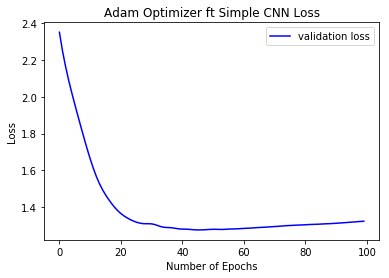

In [52]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(losses, color='b', label="validation loss")
plt.title("Adam Optimizer ft Simple CNN Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

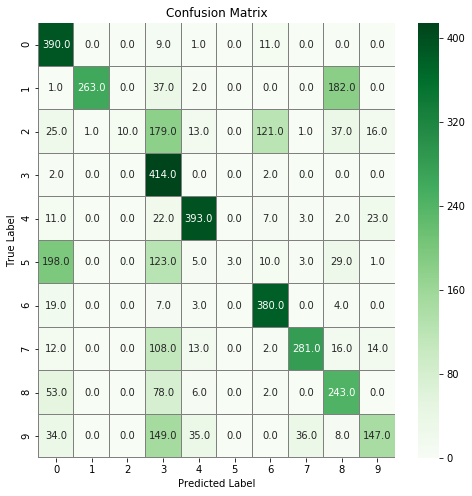

In [53]:
# Predict the values from the validation dataset
Y_pred = predict(X_val, dense_in, relu_in, dense_out)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [54]:
from sklearn.metrics import classification_report


# True and predicted labels
true_labels = []
pred_labels = []
for i in range(10):
    for j in range(10):
        true_labels.extend([i] * int(confusion_mtx[i][j]))
        pred_labels.extend([j] * int(confusion_mtx[i][j]))

# Calculate classification report
report = classification_report(true_labels, pred_labels, output_dict=True)
report_table = [(label, round(m['precision'], 3), round(m['recall'], 3), round(m['f1-score'], 3)) 
                for label, m in report.items() if label.isdigit()]

df = pd.DataFrame(report_table, columns=['Class', 'Precision', 'Recall', 'F1-Score'])
df

,Class,Precision,Recall,F1-Score
0,0,0.523,0.949,0.675
1,1,0.996,0.542,0.702
2,2,1.000,0.025,0.048
3,3,0.368,0.990,0.536
4,4,0.834,0.852,0.843
5,5,1.000,0.008,0.016
6,6,0.710,0.920,0.802
7,7,0.867,0.630,0.730
8,8,0.466,0.636,0.538
9,9,0.731,0.359,0.482


<a id="12"></a>
### Define Optimizer   
* Adam optimizer: Change the learning rate


<a id="13"></a>
### Compile Model
* categorical crossentropy
* We make binary cross entropy at previous parts and in machine learning tutorial
* At this time we use categorical crossentropy. That means that we have multi class.
* <a href="https://ibb.co/jm1bpp"><img src="https://preview.ibb.co/nN3ZaU/cce.jpg" alt="cce" border="0"></a>


In [ ]:
# # Compile the model
# model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<a id="14"></a>
### Epochs and Batch Size
* Say you have a dataset of 10 examples (or samples). You have a **batch size** of 2, and you've specified you want the algorithm to run for 3 **epochs**. Therefore, in each epoch, you have 5 **batches** (10/2 = 5). Each batch gets passed through the algorithm, therefore you have 5 iterations **per epoch**.
* reference: https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

In [ ]:
# epochs = 10  # for better result increase the epochs
# batch_size = 250

<a id="15"></a>
### Data Augmentation
* To avoid overfitting problem, we need to expand artificially our handwritten digit dataset
* Alter the training data with small transformations to reproduce the variations of digit.
* For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated.
* <a href="https://ibb.co/k24CUp"><img src="https://preview.ibb.co/nMxXUp/augment.jpg" alt="augment" border="0"></a>
    


In [26]:
# # data augmentation
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # dimesion reduction
#         rotation_range=5,  # randomly rotate images in the range 5 degrees
#         zoom_range = 0.1, # Randomly zoom image 10%
#         width_shift_range=0.1,  # randomly shift images horizontally 10%
#         height_shift_range=0.1,  # randomly shift images vertically 10%
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# datagen.fit(X_train)

<a id="16"></a>
### Fit the model

In [ ]:
# # Fit the model
# history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

<a id="17"></a>
### Evaluate the model
* Test Loss visualization
* Confusion matrix


In [ ]:
# # Plot the loss and accuracy curves for training and validation 
# plt.plot(history.history['val_loss'], color='b', label="validation loss")
# plt.title("Test Loss")
# plt.xlabel("Number of Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [ ]:
# # confusion matrix
# import seaborn as sns
# # Predict the values from the validation dataset
# Y_pred = model.predict(X_val)
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# # Convert validation observations to one hot vectors
# Y_true = np.argmax(Y_val,axis = 1) 
# # compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# # plot the confusion matrix
# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

<a id="18"></a>
## Conclusion
* http://scs.ryerson.ca/~aharley/vis/conv/flat.html
* HW
* If you have any question I will be very happy to hear it.